<a href="https://colab.research.google.com/github/atiyehghm/DeepLearningSelfStudy/blob/main/Vision_transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Transformer

This notebook focuses on implementing VIT for Mnist dataset.

[The main article on medium](https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)

In [5]:
! pip install tqdm

In [6]:
import numpy as np
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

## Implementing the VIT

![picture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

In [16]:
## Step1: patchify the image : (N, C, H, W) ---> (N, #of patches, patch dimensionality)
## in our example which is a 28x28 image we convert it to 49 4x4 patches
## Todo: Look for more efficient ways to do this

def patchify(images, n_patches):
  n,c, h, w = images.shape

  images = images.cpu()
  assert h==w, "Patchify only works for square images"
  patch_size = h//n_patches
  patches = np.zeros((n, n_patches**2, (c*h*w)//(n_patches**2)))

  for idx, image in enumerate(images):
    for i in range(n_patches):
      for j in range(n_patches):
        patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        patches[idx, i*n_patches + j] = patch.flatten()

  return patches

In [17]:
## Testing the patchify
x = torch.randn(7, 1, 28, 28) # Dummy images
print(patchify(x, 7).shape) # torch.Size([7, 49, 16])

(7, 49, 16)


**ABOUT V-Class TOKEN**

Simply put, this is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block (later on). When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

**Postional Encoding**
it allows the transformer to understand where is each patch in the image.


In [18]:
def get_positional_embeddings(seq_len, seq_dim):
  embedding = np.zeros((seq_len, seq_dim))
  for i in range(seq_len):
    for j in range(seq_dim):
      if j % 2 == 0:
        embedding[i][j] = np.sin(i / (10000**(j/seq_dim)))
      else:
        embedding[i][j] = np.cos(i / (10000**((j-1)/seq_dim)))
  return embedding

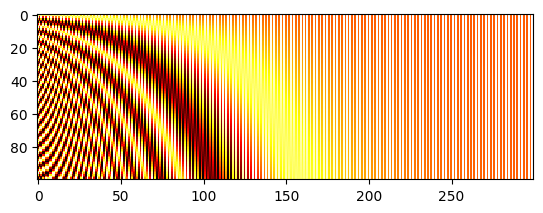

In [19]:
import matplotlib.pyplot as plt

plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

**Multihead Self-Attention**

In [20]:
class multiHeadSelfAttention(nn.Module):
  def __init__(self, d, n_heads=2):
    super(multiHeadSelfAttention, self).__init__()
    self.d = d
    self.n_heads = n_heads

    assert d%n_heads == 0, f'Can\'t divide {d} dimensions to {n_heads}!!'

    self.d_head = int(d / n_heads)
    self.q_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
    self.k_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
    self.v_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])

    self.softmax = nn.Softmax(dim = -1)

  def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [21]:
class transformerEncoderBlock(nn.Module):
  def __init__(self, hidden_d, n_heads, mlp_ratio=4):
    super(transformerEncoderBlock, self).__init__()

    self.n_heads = n_heads
    self.hidden_d = hidden_d

    self.lnorm = nn.LayerNorm(self.hidden_d)
    self.mhsa = multiHeadSelfAttention(self.hidden_d, self.n_heads)

    self.lnorm2 = nn.LayerNorm(self.hidden_d)
    self.mlp = nn.Sequential(
      nn.Linear(self.hidden_d, self.hidden_d*mlp_ratio),
      nn.GELU(),
      nn.Linear(self.hidden_d*mlp_ratio, self.hidden_d)
    )

  def forward(self, x):
    output = x + self.mhsa(self.lnorm(x))
    output = output + self.mlp(self.lnorm2(output))

    return output

**Final VIT class**

In [34]:
'''
hidden_d: dimension of the output of linear mapping
'''

class VIT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, n_out=10):
    super(VIT, self).__init__()

    self.chw = chw
    self.n_patches = n_patches
    self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)
    self.n_blocks = n_blocks
    self.n_heads = n_heads
    self.hidden_d = hidden_d
    print(chw)
    assert chw[1]%n_patches==0, "Input is not divisible by the number of patches"
    assert chw[2]%n_patches==0, "Input is not divisible by the number of patches"

    ## Linear mapping
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    ## Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    ## Positional embeddings
    self.register_buffer('positional_embeddings', torch.from_numpy(get_positional_embeddings(n_patches ** 2 + 1, hidden_d)), persistent=False)

    ## Transformer encoder blocks
    self.blocks = nn.ModuleList([transformerEncoderBlock(self.hidden_d, self.n_heads) for _ in range(self.n_blocks)])

    ## Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_d, n_out),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = torch.from_numpy(patchify(images, self.n_patches)).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        print(patches.dtype)
        patches = patches.float()
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

## Testing VIT

In [ ]:
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = VIT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, n_out=10).to(device)
N_EPOCHS = 5
LR = 0.005

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")